In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import os 

df = pd.read_csv('../data/trainings_df.csv',index_col=0)
df.pop('missing_values')
df['missing_values'] = df.isna().sum(axis=1)
df.head()

,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx,year,day,month,hour,minutes,weekday,time_as_number,date_time,missing_values
Datum,,,,,,,,,,,,,,,,
02.01.1962,9:00,NaN,4.6,NaN,NaN,NaN,NaN,1962,2,1,9.0,0,1,9.0,1962-01-02 09:00:00,5
03.01.1962,9:00,NaN,5.1,NaN,NaN,NaN,NaN,1962,3,1,9.0,0,2,9.0,1962-01-03 09:00:00,5
04.01.1962,9:00,NaN,4.3,NaN,NaN,NaN,NaN,1962,4,1,9.0,0,3,9.0,1962-01-04 09:00:00,5
05.01.1962,9:00,NaN,5.1,NaN,NaN,NaN,NaN,1962,5,1,9.0,0,4,9.0,1962-01-05 09:00:00,5
08.01.1962,9:00,NaN,5.1,NaN,NaN,NaN,NaN,1962,8,1,9.0,0,0,9.0,1962-01-08 09:00:00,5


In [2]:
df['datum'] = df.index
df.index = pd.to_datetime(df.index + " " + df.Uhrzeit,format='%d.%m.%Y %H:%M')
df['time_as_number'] = df.index.hour + df.index.minute/60
df.head(1)

,Uhrzeit,SECCI,Temperatur,Salinität,NO2,NO3,NOx,year,day,month,hour,minutes,weekday,time_as_number,date_time,missing_values,datum
1962-01-02 09:00:00,9:00,NaN,4.6,NaN,NaN,NaN,NaN,1962,2,1,9.0,0,1,9.0,1962-01-02 09:00:00,5,02.01.1962


In [3]:
submission_ds = pd.read_csv('../data/bbdc_student/bbdc_2023_AWI_data_evaluate_skeleton_student.csv', delimiter=';',skiprows=[1],index_col=0)
submission_ds['datum'] =submission_ds.index
submission_ds.index = pd.to_datetime(submission_ds.index + " " + submission_ds.Uhrzeit,format='%d.%m.%Y %H:%M')
submission_ds

submission_ds['time_as_number'] = submission_ds.index.hour + submission_ds.index.minute/60

times = pd.concat((df[['time_as_number','datum']], submission_ds[['time_as_number','datum']])).set_index('datum')
times.index = pd.to_datetime(times.index,format='%d.%m.%Y')

In [4]:
cols = df.isna().sum(0)
cols = cols.loc[cols > 0].index
cols 

Index(['SECCI', 'Temperatur', 'Salinität', 'NO2', 'NO3', 'NOx'], dtype='object')

Method interpolate with time was best

In [5]:
df.loc[:,cols] = df[cols].interpolate(method='time')

In [6]:
df.index = pd.to_datetime(df.datum,format='%d.%m.%Y')

In [7]:
df.isna().sum()

Uhrzeit              0
SECCI             1343
Temperatur           0
Salinität            6
NO2                  6
NO3                  6
NOx               9996
year                 0
day                  0
month                0
hour                 0
minutes              0
weekday              0
time_as_number       0
date_time            0
missing_values       0
datum                0
dtype: int64

In [8]:
df = df.loc[df.index.year >= 1968] 

In [9]:
#df.loc[df.SECCI.isna(),'SECCI'] = df.SECCI.mean() + np.random.normal(0,0.2,size=(df.SECCI.isna().sum()))
df.loc[df.NO3.isna(),'Salinität'] = df.Salinität.mean() + np.random.normal(0,0.2,size=(df.Salinität.isna().sum()))
df.loc[df.NO3.isna(),'NO2'] = df.NO2.mean() + np.random.normal(0,0.2,size=(df.NO2.isna().sum()))
df.loc[df.NO3.isna(),'NO3'] = df.NO3.mean() + np.random.normal(0,0.2,size=(df.NO3.isna().sum()))

In [10]:
import json
with open('../data/bbdc_student/means.json',"r") as f:
    means = pd.Series(json.load(f))
    
with open('../data/bbdc_student/variances.json',"r") as f:
    stds = pd.Series(json.load(f))
    stds = np.sqrt(stds)

In [11]:
means

SECCI          3.675383
Temperatur    10.480963
Salinität     32.217400
NO2            0.553468
NO3            9.538840
NOx           10.094147
dtype: float64

In [12]:
stds

SECCI         1.804576
Temperatur    4.984322
Salinität     1.054333
NO2           0.716608
NO3           8.747042
NOx           8.889739
dtype: float64

In [13]:
df = df[stds.index]

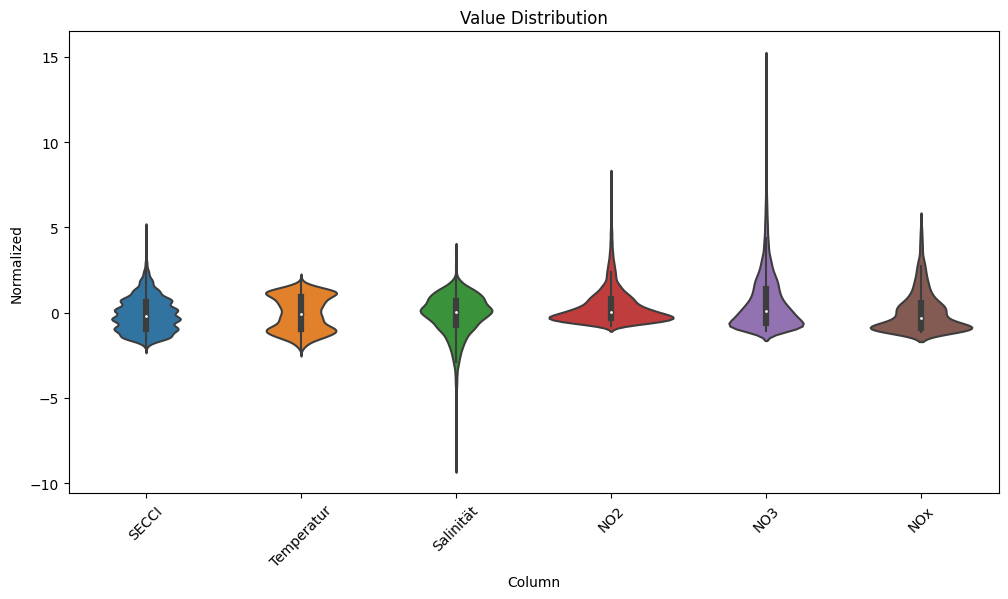

In [14]:
df = (df- means) / stds


df_std = df.melt(var_name='Column', value_name='Normalized').dropna()
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
plt.xticks(rotation = 45)
plt.title("Value Distribution")
plt.show()

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SECCI,10114.0,-0.087815,1.008570,-2.036702,-0.928408,-0.208017,0.623203,4.890133
Temperatur,10117.0,-0.048453,1.012598,-2.223163,-0.979263,-0.076432,0.926713,1.949922
Salinität,10117.0,-0.114838,1.177372,-8.984260,-0.735442,0.050837,0.712972,3.688209
NO2,10117.0,0.382806,1.039082,-0.765082,-0.311842,0.064933,0.776619,8.019069
NO3,10117.0,0.657962,1.728017,-1.089379,-0.588638,0.124746,1.398319,14.709104
NOx,1461.0,0.058226,1.208258,-1.134358,-0.890256,-0.315436,0.570979,5.289903


In [16]:
df.to_csv('../data/data_for_darts_normalized_by_test.csv')